# Data Preparation and Scenario for modelling

# Data Preparation

### Missing Value

Kita akan melakukan handling terhadap data yang null atau nan.

In [19]:
df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

**Handling kolom children**

Untuk kolom children yang nan disebabkan karena customer tidak mengisi jumlah children yang mereka bawa. Maka dari itu, kita lakukan handling dengan menganggap bahwa mereka tidak membawa children sama sekali. 

In [20]:
df['children'] = df.apply(lambda x: 0 if np.isnan(x['children']) else x['children'], axis = 1)

**Handling kolom country**

karena dari 488 data country yang hilang tersebut tidak diketahui alasannya dan jika kita fillna dengan modus, dikhawatirkan nanti model kita biasnya akan meningkat.

In [21]:
df.dropna(subset=['country'], inplace = True)

**Handling kolom Agent**

Terdapat 16.340 data yang missing pada kolom agent, data nan tersebut sekitar 13,6% maka dari itu bisa kita handling dengan melakukan drop pada kolom nan tersebut

In [22]:
df.dropna(subset=['agent'], inplace = True)

**Handling kolom Company**

Karena pada data kita missing pada kolom company mencapai 94% maka dari itu perlu kita lakukan drop. Dan, karena kolom agent berhubungan dengan kolom company maka dari itu kolom agent perlu kita drop juga.

In [23]:
df.drop(['company'], axis = 1, inplace = True)

Pengecekan setelah apakah data nan sudah terhandling semua

In [24]:
df.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces 

Jumlah data setelah dilakukan handling missing value

In [25]:
len(df)

102896

### Invalid Values

In [26]:
# kita cek apa ada invalid values pada dataset, apa terdapat data booking pada kolom `adult`,`children` dan `babies' yang bernilai 0 pada waktu yang bersamaan

df[(df['adults']==0)&(df['children']==0)&(df['babies']==0)].shape[0]

120

Terdapat **120** data invalid pada dataset yang perlu dihandle

In [27]:
df=df[~((df['adults']==0)&(df['children']==0)&(df['babies']==0))]
df.shape

(102776, 35)

In [28]:
df[(df['adults']==0)&(df['children']==0)&(df['babies']==0)].shape[0]

0

In [29]:
print('Jumlah data setelah remove invalid value:', len(df))

Jumlah data setelah remove invalid value: 102776


#### Menghilangkan adr bernilai negatif

In [30]:
df = df[~(df.adr < 0)]

In [31]:
df[(df.adr < 0)]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card


### Duplicate Data

In [32]:
df.duplicated().sum()

0

In [33]:
df.duplicated(subset=['name', 'email', 'reservation_status_date']).sum()

0

**Berdasarkan hasil pemeriksaan data duplikat di atas, tidak terdapat data booking yang terduplikasi**


### Invalid Data type

In [34]:
df.agent = df.agent.astype('int64')

In [35]:
df.agent = df.agent.astype('object')

In [36]:
df_clean = df.copy()

### Feature Engineering

In [37]:
from datetime import datetime as dt

def feature_engineering(df_fe):
    df_fe['total_people'] = df_fe['adults'] + df_fe['babies'] + df_fe['children']
    df_fe['total_stays_night'] = df_fe['stays_in_weekend_nights']+df_fe['stays_in_week_nights']
    df_fe['last_name'] = df_fe['name'].apply(lambda x: str(x).split()[1])
    df_fe['prefix_phone_number'] = df_fe['phone-number'].apply(lambda x: x[0:3])
    df_fe['arrival_date'] = df_fe.apply(lambda x: dt.strptime(str(x['arrival_date_day_of_month'])+' '+str(x['arrival_date_month'])+' '+str(x['arrival_date_year']), '%d %B %Y'), axis = 1)
    df_fe['reservation_status_date'] = df_fe['reservation_status_date'].apply(lambda x: dt.strptime(x, '%Y-%m-%d'))
    df_fe['cancellation_time'] = df_fe.apply(lambda x: -1 if x['reservation_status'] == 'Check-Out' else (x['arrival_date'] - x['reservation_status_date']).days, axis = 1)
    df_fe['email_type'] = df_fe.apply(lambda x: str(x['email']).split('@')[1].split('.')[0], axis = 1)
    df_fe['was_in_waiting_list'] = df_fe.apply(lambda x: 1 if x['days_in_waiting_list'] > 0 else 0, axis = 1)
    return df_fe

## Baseline

### Feature Selection

In [38]:
df_bl = df_clean.copy()

df_bl = df_bl[['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests']]

### Feature Encoding

In [40]:
categorical_features = df_bl.loc[:, df_bl.columns != 'is_canceled'].select_dtypes(['object']).columns.to_list()
categorical_features

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'agent',
 'customer_type']

In [41]:
df_encode_bl = df_bl.copy()

for cat in categorical_features:
    onehots = pd.get_dummies(df_encode_bl[cat], prefix=cat)
    df_encode_bl = df_encode_bl.join(onehots)

df_encode_bl.drop(categorical_features, axis = 1, inplace = True)

## Scenario 0

### Feature Engineering

In [42]:
#Data Scenario 0

df_clean_fe = df_clean.copy()
df_clean_fe['reservation_status_date']=df_clean_fe['reservation_status_date'].astype('str')
df_clean_fe = feature_engineering(df_clean_fe)

In [43]:
df_clean_fe.arrival_date.sort_values()

3        2015-07-01
75551    2015-07-01
75552    2015-07-01
75553    2015-07-01
75554    2015-07-01
            ...    
73713    2017-08-31
40007    2017-08-31
119281   2017-08-31
39953    2017-08-31
73712    2017-08-31
Name: arrival_date, Length: 102775, dtype: datetime64[ns]

### Feature Selection

In [44]:
df_clean_fs = df_clean_fe.copy()

df_clean_fs = df_clean_fs[['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'total_people', 'total_stays_night',
       'last_name', 'prefix_phone_number',
       'email_type', 'was_in_waiting_list']]

### Feature Encoding

In [45]:
cats = [i for i in df_clean_fs.columns if (df_clean_fs[i].dtypes == 'O')] 

df_encode_0 = df_clean_fs.copy()

for cat in cats:
    onehots = pd.get_dummies(df_encode_0[cat], prefix=cat)
    df_encode_0 = df_encode_0.join(onehots)

df_encode_0 = df_encode_0.drop(cats, axis = 1)

## Scenario 1

### Outliers

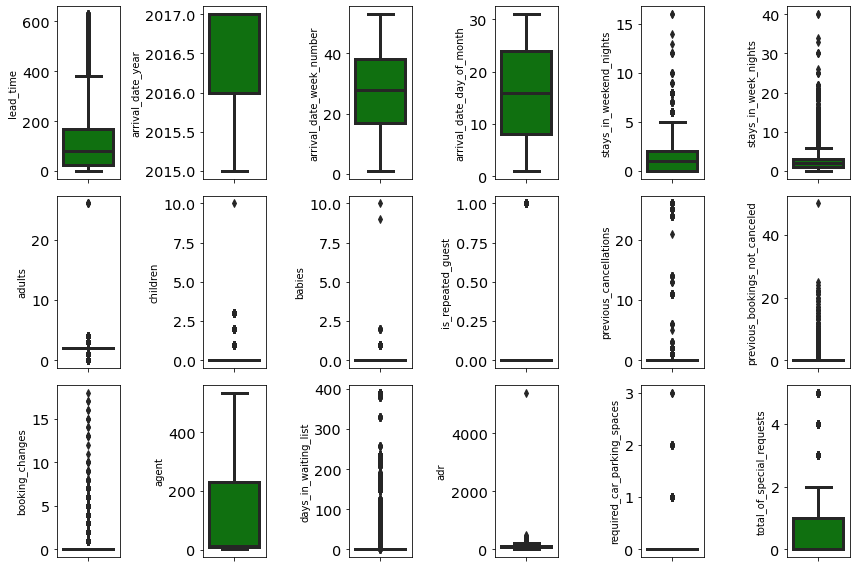

In [46]:
plt.figure(figsize=(12,8))
for i in range(0, len(nums)):
    plt.subplot(3, 6, i+1)
    sns.boxplot(y=df[nums[i]], color='green', orient='v')
    plt.tight_layout()

### Trimming outlier pada previous_bookings_not_canceled

Menghilangkan 1 row data dengan previous booking not canceled sangat tinggi yaitu 50

In [47]:
df = df[~(df.previous_bookings_not_canceled > 40)]

### Log Transformation

The transformation preserves zero: a value that is 0 in the original scale is also 0 in the transformed scale. The function acts like the log (base 10) function when x > 0. Notice that L(10) ≈ 1, L(100) ≈ 2, and L(1000) ≈ 3. This property makes it easy to interpret values of the transformed data in terms of the scale of the original data. Negative values are transformed similarly.

In [48]:
feature_log = ['children', 'babies', 'required_car_parking_spaces', 'adults', 'stays_in_weekend_nights', 'stays_in_week_nights', 
               'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'total_of_special_requests']

for i in feature_log:
    df[i] = df[i].apply(lambda x: np.log(x) if x != 0 else 0)

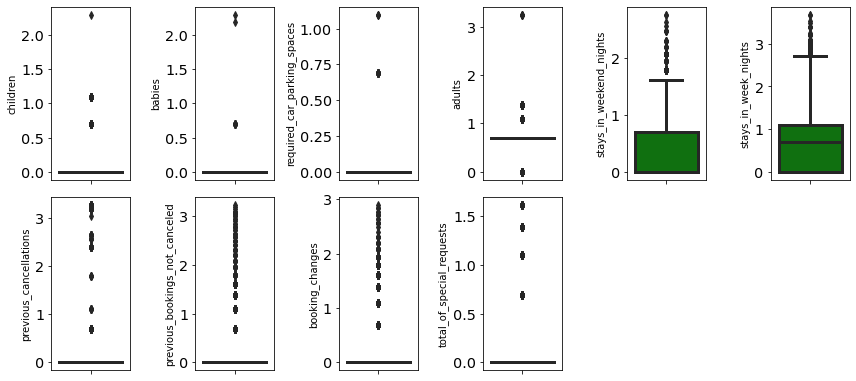

In [49]:
plt.figure(figsize=(12,8))
for i in range(0, len(feature_log)):
    plt.subplot(3, 6, i+1)
    sns.boxplot(y=df[feature_log[i]], color='green', orient='v')
    plt.tight_layout()

### Z-Score

In [50]:
df_zscore=df.copy()

In [51]:
from scipy import stats

print(f'Jumlah baris sebelum memfilter outlier: {len(df_zscore)}')

filtered_entries = np.array([True] * len(df_zscore))

for col in ['lead_time', 'days_in_waiting_list', 'adr']:
    zscore = abs(stats.zscore(df_zscore[col]))
    filtered_entries = (zscore < 3) & filtered_entries
    
df_zscore = df_zscore[filtered_entries]

print(f'Jumlah baris setelah memfilter outlier: {len(df_zscore)}')

df_zscore = df_zscore.reset_index(drop = True)

Jumlah baris sebelum memfilter outlier: 102774
Jumlah baris setelah memfilter outlier: 98963


**Data Setelah dilakukan handling outlier**

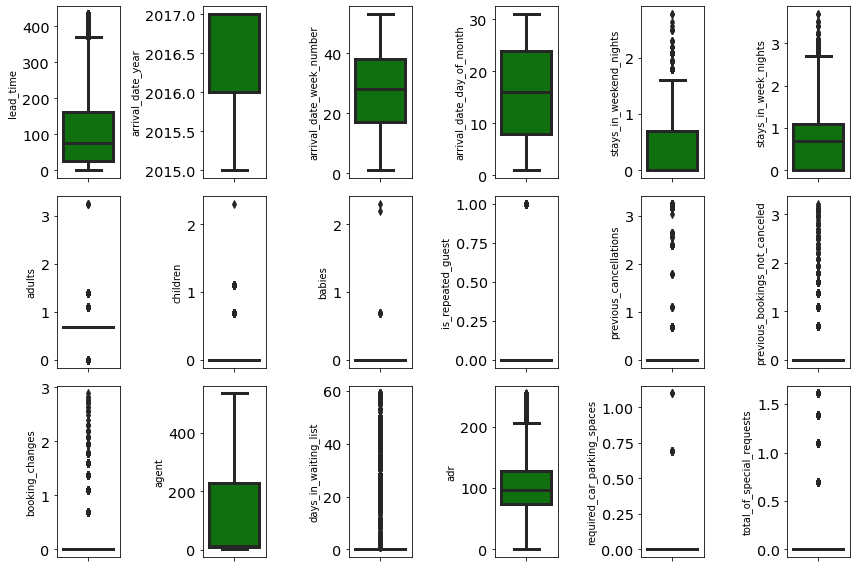

In [52]:
plt.figure(figsize=(12,8))
for i in range(0, len(nums)):
    plt.subplot(3, 6, i+1)
    sns.boxplot(y=df_zscore[nums[i]], color='green', orient='v')
    plt.tight_layout()

In [53]:
#Data Scenario 1

df_fe = df_zscore.copy()
df_fe = feature_engineering(df_fe)

### Feature Selection

In [54]:
df_fs = df_fe.copy()

df_fs = df_fs[['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 'total_people', 'total_stays_night',
       'last_name', 'prefix_phone_number',
       'email_type', 'was_in_waiting_list']]

### Normalization / Standarization

In [55]:
numerical = [i for i in df_fs.columns if (df_fs[i].dtypes in ['float64', 'int64']) and (i not in (['is_canceled', 'is_repeated_guest', 'was_in_waiting_list']))]

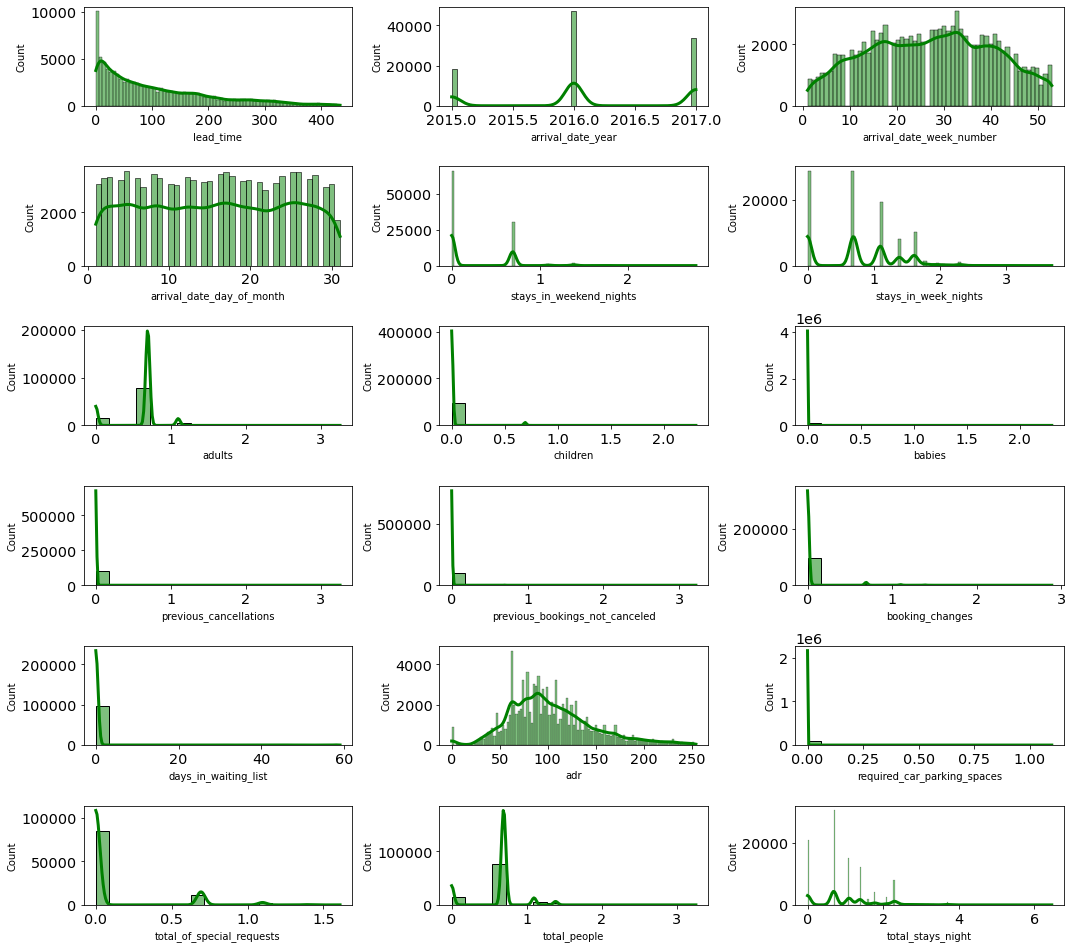

In [56]:
plt.figure(figsize = (15, 15))
for i in range(len(numerical)):
    plt.subplot(7, 3, i+1)
    sns.histplot(x = df_fs[numerical[i]], kde = True, color = 'green')
    plt.tight_layout()

In [57]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df_fs['lead_time'] = MinMaxScaler().fit_transform(df_fs['lead_time'].values.reshape(len(df_fs), 1))
df_fs['required_car_parking_spaces'] = MinMaxScaler().fit_transform(df_fs['required_car_parking_spaces'].values.reshape(len(df_fs), 1))
df_fs['children'] = MinMaxScaler().fit_transform(df_fs['children'].values.reshape(len(df_fs), 1))
df_fs['adults'] = MinMaxScaler().fit_transform(df_fs['adults'].values.reshape(len(df_fs), 1))
df_fs['stays_in_weekend_nights'] = MinMaxScaler().fit_transform(df_fs['stays_in_weekend_nights'].values.reshape(len(df_fs), 1))
df_fs['stays_in_week_nights'] = MinMaxScaler().fit_transform(df_fs['stays_in_week_nights'].values.reshape(len(df_fs), 1))
df_fs['previous_cancellations'] = MinMaxScaler().fit_transform(df_fs['previous_cancellations'].values.reshape(len(df_fs), 1))
df_fs['previous_bookings_not_canceled'] = MinMaxScaler().fit_transform(df_fs['previous_bookings_not_canceled'].values.reshape(len(df_fs), 1))
df_fs['booking_changes'] = MinMaxScaler().fit_transform(df_fs['booking_changes'].values.reshape(len(df_fs), 1))
df_fs['total_of_special_requests'] = MinMaxScaler().fit_transform(df_fs['total_of_special_requests'].values.reshape(len(df_fs), 1))

### Feature Encoding

In [58]:
cats = ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 
        'assigned_room_type', 'deposit_type', 'customer_type', 'email_type', 'last_name', 'prefix_phone_number', 'agent']

df_fs['arrival_date_month'] = df_fs['arrival_date_month'].astype('object')

for i in cats:
    print(f'Jumlah unique {i}: ', len(df_fs[i].unique()))

Jumlah unique hotel:  2
Jumlah unique arrival_date_month:  12
Jumlah unique meal:  5
Jumlah unique country:  172
Jumlah unique market_segment:  7
Jumlah unique distribution_channel:  5
Jumlah unique reserved_room_type:  8
Jumlah unique assigned_room_type:  10
Jumlah unique deposit_type:  3
Jumlah unique customer_type:  4
Jumlah unique email_type:  13
Jumlah unique last_name:  1386
Jumlah unique prefix_phone_number:  900
Jumlah unique agent:  329


#### Menggunakan feature hasher untuk kolom yang memiliki banyak jumlah unique value

In [59]:
from sklearn.feature_extraction import FeatureHasher

var_fh = ['country', 'last_name', 'prefix_phone_number']
df_fh = df_fs.copy()

for col in var_fh: 
    if col == 'country':
        fh = FeatureHasher(n_features = 4, input_type = 'string')
        sp = fh.fit_transform(df_fh[col])
        df_transform = pd.DataFrame(sp.toarray(), columns=[str(col) + '_' + str(i) for i in range(1, 5)])
        df_fh = pd.concat([df_fh, df_transform], axis=1)
    elif (col == 'last_name') | (col == 'prefix_phone_number'):
        fh = FeatureHasher(n_features = 10, input_type = 'string')
        sp = fh.fit_transform(df_fh[col])
        df_transform = pd.DataFrame(sp.toarray(), columns=[str(col) + '_' + str(i) for i in range(1, 11)])
        df_fh = pd.concat([df_fh, df_transform], axis=1)

In [60]:
df_fh.drop(['country', 'last_name', 'prefix_phone_number'], axis = 1, inplace = True)

In [61]:
cats = ['hotel', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 
        'assigned_room_type', 'deposit_type', 'customer_type', 'email_type', 'agent']

df_encode = df_fh.copy()

for cat in cats:
    onehots = pd.get_dummies(df_encode[cat], prefix=cat)
    df_encode = df_encode.join(onehots)

In [62]:
df_encode.drop(columns = cats, inplace = True)

### Imbalance Dataset

In [63]:
df_encode.is_canceled.value_counts()

0    61034
1    37929
Name: is_canceled, dtype: int64

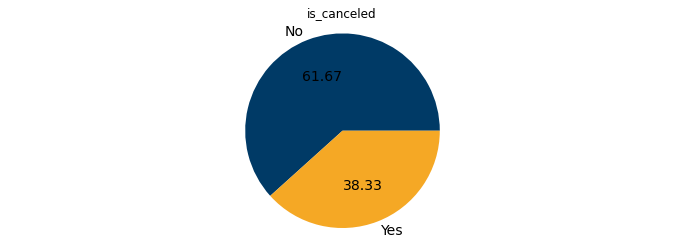

In [64]:
value_counts = df_encode["is_canceled"].value_counts().to_dict()
fig, ax = plt.subplots()
_ = ax.pie(x=[value_counts[0], value_counts[1]], labels=['No', 'Yes'], 
           colors=['#003A66', '#F5A825'], textprops={'color': '#000000', 'fontsize':'14'}, autopct='%.2f')
_ = ax.axis('equal')
_ = ax.set_title('is_canceled')